# Avro Fundamentals

**Avro as a Data Flow Format**

The goal is to create two connected Flume agents. We will establish a data flow by linking these two agents. To create a data flow across multiple agents or hops, the receiver of the previous agent and the source of the current hop must both be of the Avro type. The receiver should point to the hostname (or IP address) and the port of the source. In this case, we will use port 41414.



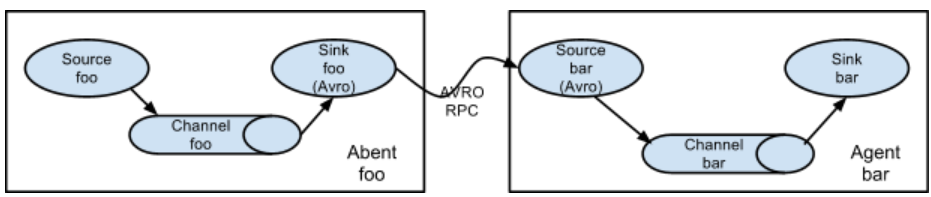

The data we will be using is a JSON file containing user data. We will place this file in a folder we create at `media/notebooks/avro/ejemplo-avro`. Additionally, we will create another folder to store the configuration files and one more for any schemas we wish to define.

## Create Folders and Data Files

In [1]:
# Create the avro, data and schematics folder
! mkdir -p /media/notebooks/avro
! mkdir -p /media/notebooks/avro/ejemplo-avro
! mkdir -p /media/notebooks/avro/esquemas
! mkdir -p /media/notebooks/avro/configuraciones

In [2]:
# Move to the folder to save data
import os
os.chdir("/media/notebooks/avro/ejemplo-avro")
! pwd

/media/notebooks/avro/ejemplo-avro


Create `users.json` file:

In [3]:
%%writefile users.json
[
     {"name": "David", "email": "david@avro.com", "age": 28},
     {"name": "Pablo", "email": "pablo@avro.com", "age": 31},
     {"name": "Ines", "email": "ines@avro.com", "age": 34}
]

Writing users.json


Move to the folder `esquemas`:

In [4]:
os.chdir("/media/notebooks/avro/esquemas")
! pwd

/media/notebooks/avro/esquemas


Create `user-schema.json` file:

In [5]:
%%writefile user-schema.json
{
     "type": "record",
     "name": "User",
     "fields": [
         {"name": "name", "type": "string"},
         {"name": "email", "type": "string"},
         {"name": "age", "type": "int"},
     ]
}

Writing user-schema.json


## Create Agents Configuration

**Agent 1**

Once the data is created, we will create two configuration files, one for each Flume agent. These configuration files will be stored in the `/media/notebooks/avro/configuraciones` folder.

The configuration file for Agent 1 involves copying the contents of the file using a `spooldir` data source, a memory channel, and an Avro sink that points to port 41414.

Move to the folder `configuraciones`:

In [6]:
os.chdir("/media/notebooks/avro/configuraciones")
! pwd

/media/notebooks/avro/configuraciones


Create `ejemplo-avro-1.config` file:

In [8]:
%%writefile ejemplo-avro-1.config
# Configure agent
agentAvro1.sources = spoolSource
agentAvro1.sinks = avroSink
agentAvro1.channels = memoryChannel

# Configure spooldir source
agentAvro1.sources.spoolSource.type = spooldir
agentAvro1.sources.spoolSource.spoolDir = /media/notebooks/avro/ejemplo-avro

# Configure channel (using memory type)
agentAvro1.channels.memoryChannel.type = memory

# Describe sink as Avro in localhost:41414
agentAvro1.sinks.avroSink.type = avro
agentAvro1.sinks.avroSink.hostname = localhost
agentAvro1.sinks.avroSink.port = 41414
agentAvro1.sinks.avroSink.serializer = avro_event

# Linking source and sink with channel
agentAvro1.sources.spoolSource.channels = memoryChannel
agentAvro1.sinks.avroSink.channel = memoryChannel

Overwriting ejemplo-avro-1.config


**Agent 2**

The agent 2 configuration file consists of creating an Avro type entry via localhost and port 41414, a memory channel and the sink pointing to HDFS.

Create `ejemplo-avro-2.config` file:

In [9]:
%%writefile ejemplo-avro-2.config
# Configure agent
agentAvro2.sources = avroSource
agentAvro2.sinks = hdfsSink
agentAvro2.channels = memChannel

# Configure source as Avro in localhost:41414
agentAvro2.sources.avroSource.type = avro
agentAvro2.sources.avroSource.bind = localhost
agentAvro2.sources.avroSource.port = 41414

# Configure channel (using memory type)
agentAvro2.channels.memChannel.type = memory

# Configure sink as hdfs
agentAvro2.sinks.hdfsSink.type = hdfs
agentAvro2.sinks.hdfsSink.hdfs.path = hdfs://namenode:9000/ejemplo-avro
agentAvro2.sinks.hdfsSink.hdfs.fileType = DataStream
agentAvro2.sinks.hdfsSink.hdfs.writeFormat = avro

# Linking source and sink with channel
agentAvro2.sources.avroSource.channels = memChannel
agentAvro2.sinks.hdfsSink.channel = memChannel

Writing ejemplo-avro-2.config


We can observe that the output of Agent 1 is in Avro format, and the input for Agent 2 is also in Avro format. This ensures that the data flow can be transmitted efficiently with the benefits of Avro format. This way, when the data reaches HDFS, we can deserialize it again after a smooth transfer.

## Run the Agents

Now that we have the configuration files and the input file ready, we need to open a terminal in our container using the command `docker exec -it namenode /bin/bash` to run Agent 2. After that, we will run Agent 1 from Jupyter. This approach ensures that no events are lost. 

First, we will launch the agent that listens on port 41414 (Agent 2), and then the one that will create the data in HDFS (Agent 1). Therefore, the sequence is: start Agent 2 first, then Agent 1.

Execute this code in the Agent 2 terminal tp start Agent 2:

```
flume-ng agent --conf ./conf/ \
    --conf-file /media/notebooks/avro/configuraciones/ejemplo-avro-2.config \
    --name agentAvro2 \
    -Dflume.root.logger=INFO,console
```

Run Agent 1 from Jupyter:

In [10]:
!flume-ng agent --conf ./conf/ \
    --conf-file /media/notebooks/avro/configuraciones/ejemplo-avro-1.config \
    --name agentAvro1 \
    -Dflume.root.logger=INFO,console

Info: Including Hadoop libraries found via (/usr/local/hadoop/bin/hadoop) for HDFS access
Info: Including Hive libraries found via (/usr/local/hive) for Hive access
+ exec /usr/lib/jvm/java-8-openjdk-amd64/bin/java -Xmx20m -Dflume.root.logger=INFO,console -cp './conf/:/usr/local/flume/lib/*:/usr/local/hadoop/etc/hadoop:/usr/local/hadoop/share/hadoop/common/lib/*:/usr/local/hadoop/share/hadoop/common/*:/usr/local/hadoop/share/hadoop/hdfs:/usr/local/hadoop/share/hadoop/hdfs/lib/*:/usr/local/hadoop/share/hadoop/hdfs/*:/usr/local/hadoop/share/hadoop/mapreduce/*:/usr/local/hadoop/share/hadoop/yarn:/usr/local/hadoop/share/hadoop/yarn/lib/*:/usr/local/hadoop/share/hadoop/yarn/*:/usr/local/hive/lib/*' -Djava.library.path=:/usr/local/hadoop/lib/native org.apache.flume.node.Application --conf-file /media/notebooks/avro/configuraciones/ejemplo-avro-1.config --name agentAvro1
SLF4J: Class path contains multiple SLF4J bindings.
SLF4J: Found binding in [jar:file:/usr/local/flume/lib/log4j-slf4j-impl

Once we have finished processing the files, we will have in the `/ejemplo-avro` folder the file with the data that we had in the `users.json`:


In [11]:
! hdfs dfs -ls /ejemplo-avro

Found 1 items
-rw-r--r--   3 root supergroup        187 2024-11-10 14:37 /ejemplo-avro/FlumeData.1731249395758


In [12]:
! hdfs dfs -cat /ejemplo-avro/FlumeData*

[
     {"name": "David", "email": "david@avro.com", "age": 28},
     {"name": "Pablo", "email": "pablo@avro.com", "age": 31},
     {"name": "Ines", "email": "ines@avro.com", "age": 34}
]
